In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-27968a8a-30e2-3b76-edde-11aa7d6d19a6)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-09-18 15:01:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-09-18 15:01:09 (7.17 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [4]:
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.isnull().sum()

Currency               0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

In [7]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


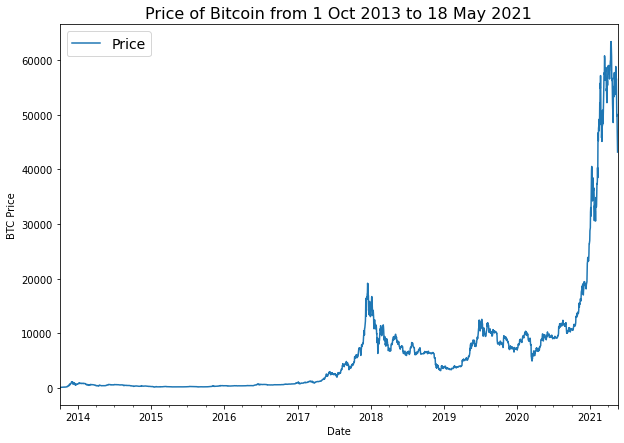

In [8]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Right way to split the data

In [9]:
timesteps = bitcoin_prices.index.to_numpy()
# timesteps[:10]
prices = bitcoin_prices["Price"].to_numpy()
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [10]:
split_size = int(len(bitcoin_prices) * 0.8)
xtrain, ytrain = timesteps[split_size:], prices[split_size:]
xtest, ytest = timesteps[:split_size], prices[:split_size]

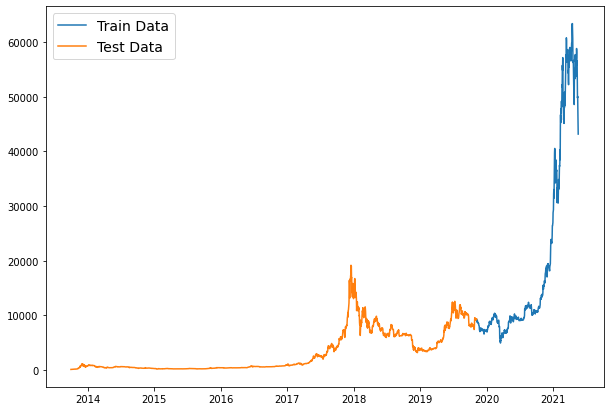

In [11]:
plt.figure(figsize = (10, 7))
plt.plot(xtrain, ytrain, label = "Train Data")
plt.plot(xtest, ytest, label = "Test Data")
plt.legend(fontsize = 14)
plt.show()

In [12]:
def plot_time_series(timesteps, prices, label = None):
  plt.plot(timesteps, prices, label = label)
  if label:
    plt.legend(fontsize = 14)

  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  plt.grid(True)  

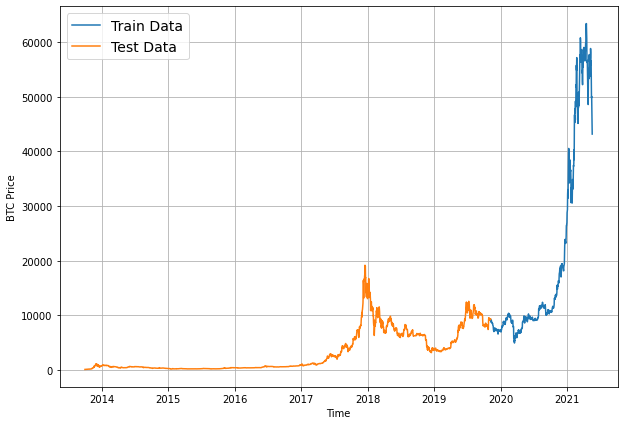

In [13]:
plt.figure(figsize = (10, 7))

plot_time_series(xtrain, ytrain, label = "Train Data")
plot_time_series(xtest, ytest, label = "Test Data")

In [14]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [16]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [17]:
# def make_windows(b, window_size = 7, horizon = 1):

#   dataset = tf.keras.utils.timeseries_dataset_from_array(data = tf.range(len(b) - window_size), 
#                                                        targets = tf.range(len(b) - window_size), 
#                                                        sequence_length = window_size,# windows 
#                                                        batch_size = 128, 
#                                                        sequence_stride = horizon # Horizon
#                                                      )
  
#   windows, label = [b[x] for x, _ in dataset], [b[y + window_size] for x, y in dataset]

#   return windows, label


In [18]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [19]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [20]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [21]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [22]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)


In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 6s 93ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 1s 54ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9993 - val_mae: 1005.9993
Epoch 3/100
18/18 [==============================] - 1s 62ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 1s 44ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 44ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2237 - val_mae: 895.2237
Epoch 6/100
18/18 [==============================] - 1s 47ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1984 - val_mae: 855.1984
Epoch 7/100
18/18 [==============================] - 1s 55ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9166 - val_mae: 840.9166
Epoch 8/100
18/1

In [24]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758


[585.9757690429688, 585.9757690429688]

In [25]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [26]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8801.183, 8714.925, 8972.653, 8760.341, 8676.046, 8679.056,
        8641.017, 8451.335, 8412.065, 8468.017], dtype=float32)>)

In [27]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [28]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [29]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 585.97577,
 'mse': 1197802.1,
 'rmse': 1094.4414,
 'mape': 2.6149104,
 'mase': 1.0293971}

## Model 2: Dense (window = 30, horizon = 1)


In [30]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [31]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [32]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [33]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [34]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332


659.3331909179688

## Prediction Using Multivariate Values

In [35]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [36]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [37]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [38]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


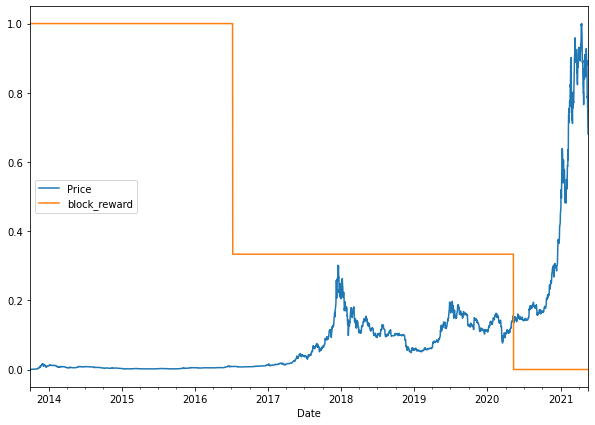

In [41]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));


In [42]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [43]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [44]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [45]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [46]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)


In [47]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [48]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8910


567.8909912109375

In [49]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [50]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.8909,
 'mse': 1164817.6,
 'rmse': 1079.2671,
 'mape': 2.5460868,
 'mase': 0.9976271}

## Model 7: N-BEATS algorithm


### Building and testing an N-BEATS block layer


In [51]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [52]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [53]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [54]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ]
Forecast: -0.7554212808609009


### Preparing data for the N-BEATS algorithm using `tf.data`


In [55]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [56]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [57]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [58]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [59]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [60]:
  # Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [61]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [64]:
#  %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 143: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 243: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [65]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 63ms/step - loss: 571.9902 - mae: 571.9902 - mse: 1172552.5000


[571.990234375, 571.990234375, 1172552.5]

In [66]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8821.601, 8763.247, 9004.704, 8761.291, 8722.632, 8703.683,
       8655.06 , 8517.257, 8414.678, 8509.037], dtype=float32)>

In [67]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 571.99023,
 'mse': 1172552.5,
 'rmse': 1082.8446,
 'mape': 2.5926774,
 'mase': 1.0048285}

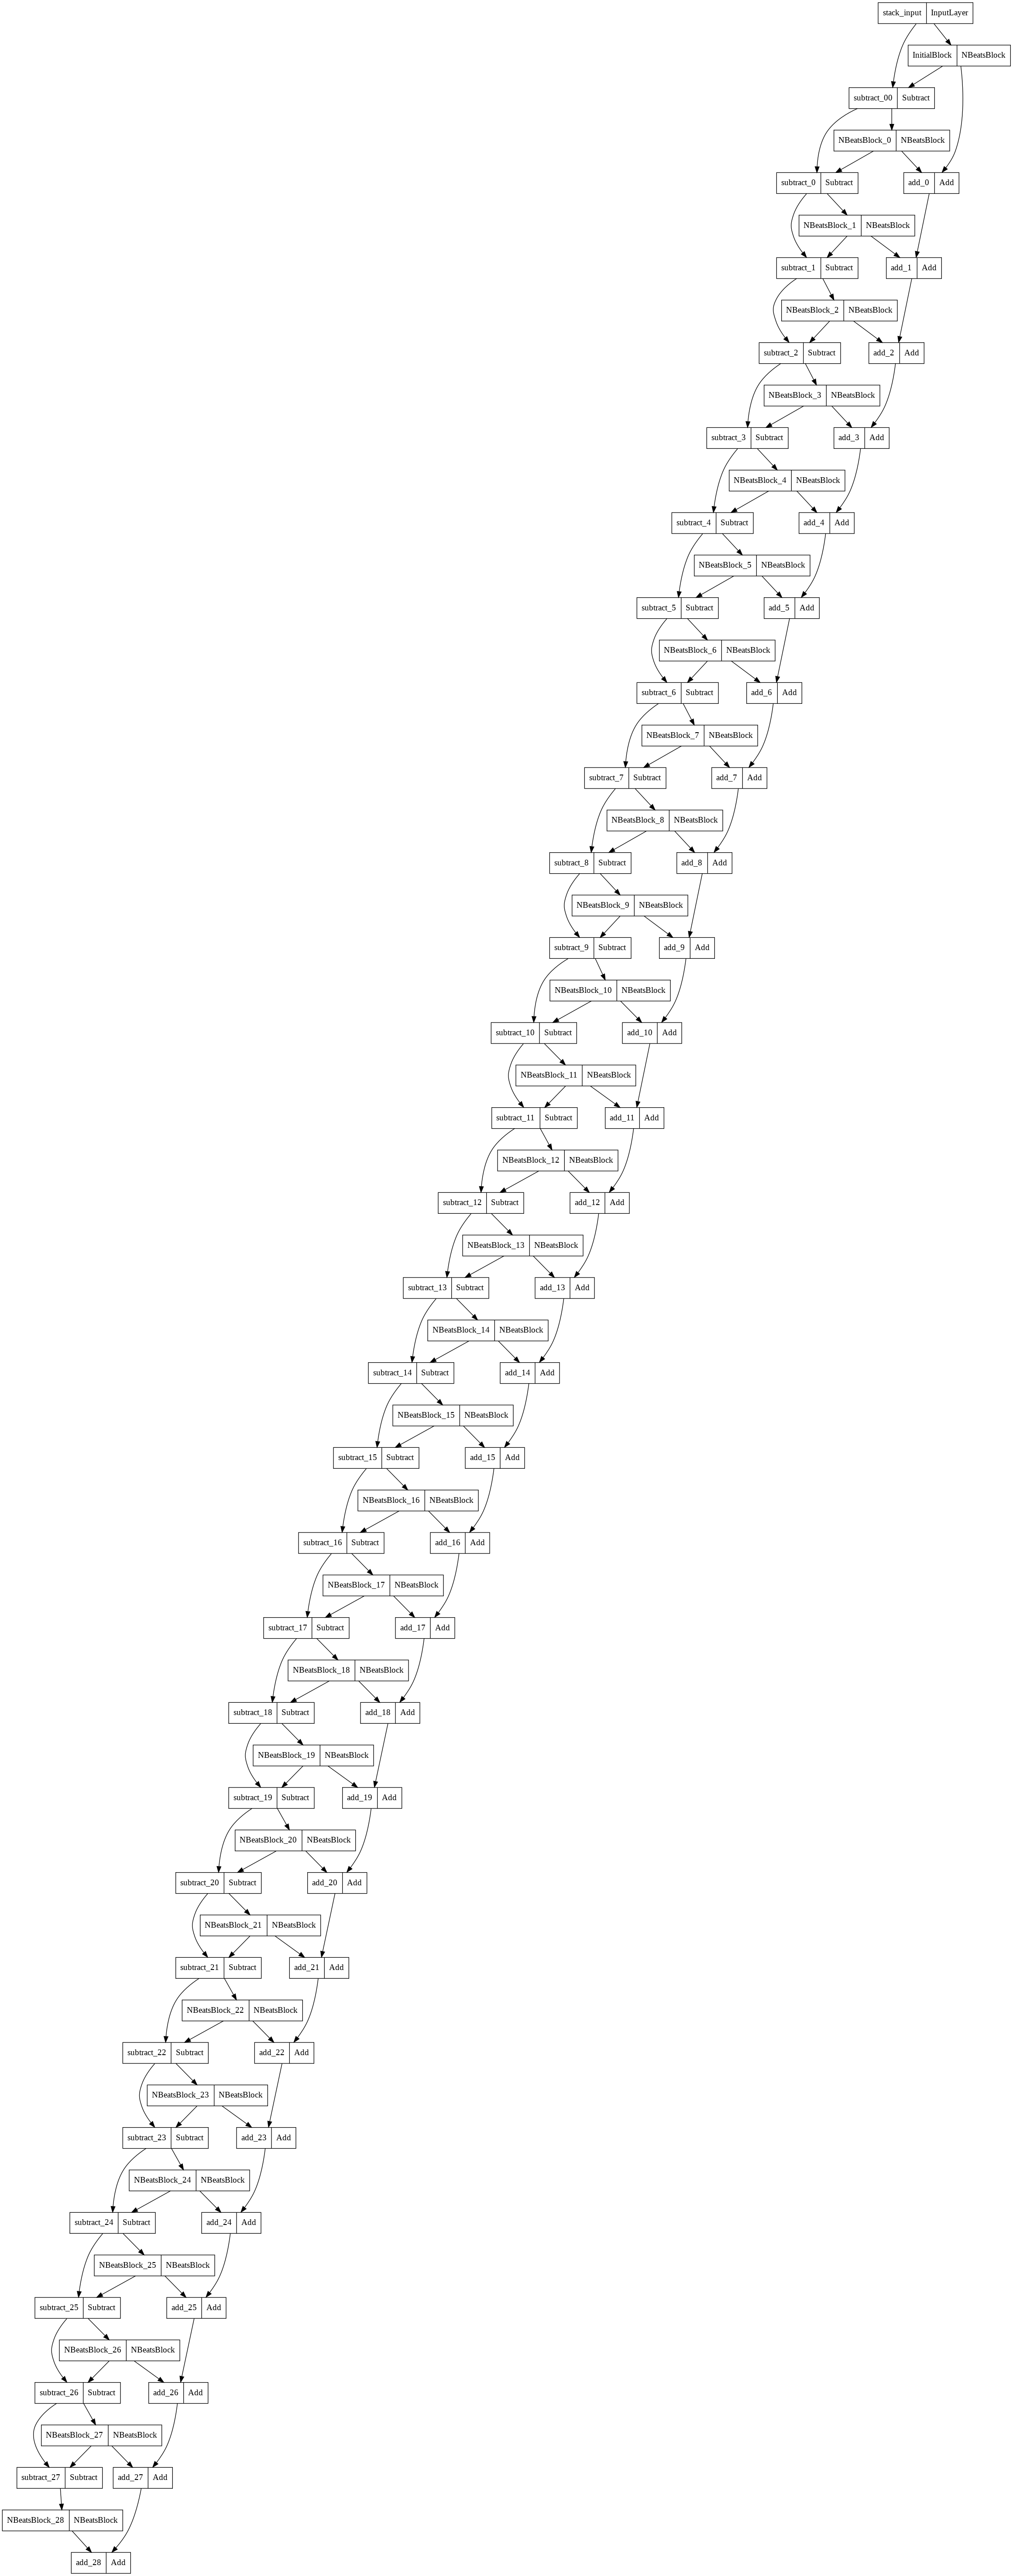

In [68]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 9: Train a model on the full historical data to make predictions into future


In [69]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [70]:
  # Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [71]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [72]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [73]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [74]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [75]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.47265625

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> Prediction: 50985.9296875

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 50985.9296875 ] -> Prediction: 48522.9609375

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 50985.9296875  48522.9609375 ] -> Prediction: 48137.19921875

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.47265625
 50985.9296875  48522.9609375  48137.19921875] -> Prediction: 47880.6328125

Predicting on: 
 [45604.61575361 43144.47129086 55764.47265625 50985.9296875
 48522.9609375  48137.19921875 47880.6328125 ] -> Prediction: 46879.71484375

Predicting on: 
 [43144.47129086 55764.47265625 50985.9296875  48522

In [76]:
future_forecast[:10]

[55764.473,
 50985.93,
 48522.96,
 48137.2,
 47880.633,
 46879.715,
 48227.594,
 53963.684,
 49685.543,
 47596.176]

In [77]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [78]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [79]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [80]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [81]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.473, 50985.93 , 48522.96 , 48137.2  , 47880.633,
        46879.715, 48227.594, 53963.684, 49685.543, 47596.176, 48114.418,
        48807.996, 48623.85 , 50178.715], dtype=float32))

In [83]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [85]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

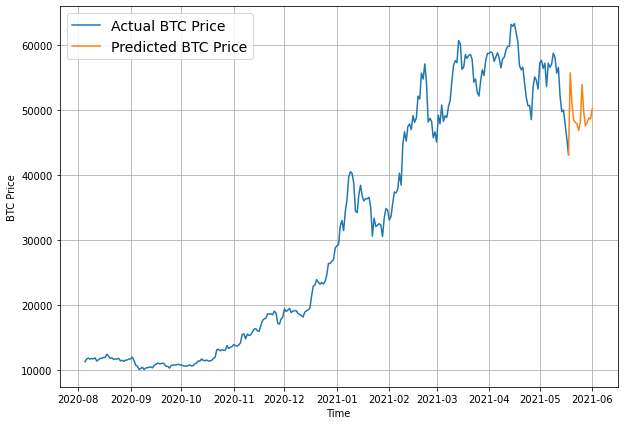

In [86]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")